In [1]:
import pandas as pd

## PATHS

In [2]:
PERIODS = 'menstrual_health_cycles.csv'
SLEEP_score = 'sleep/sleep_score.csv'

## periods

In [3]:
per = pd.read_csv(PERIODS)
per.drop(['id','ovulation_source', 'period_source', 'fertile_source', 'ovulation_start_date','ovulation_end_date','fertile_start_date','fertile_end_date'], axis=1, inplace=True)
per['cycle_start_date'] = pd.to_datetime(per['cycle_start_date'])
per['cycle_end_date'] = pd.to_datetime(per['cycle_end_date'])
per['period_start_date'] = pd.to_datetime(per['period_start_date'])
per['period_end_date'] = pd.to_datetime(per['period_end_date'])
per['cycle_length'] = per['cycle_end_date'] - per['cycle_start_date']
per['period_length'] = per['period_end_date'] - per['period_start_date']
per['cycle_length'] = pd.to_timedelta(per['cycle_length']).dt.days
per['period_length'] = pd.to_timedelta(per['period_length']).dt.days
per.drop([per.index[-1], per.index[-2], per.index[-3]], inplace=True)
#per.to_csv('interim_data/periods.csv', columns=['cycle_start_date','cycle_length','period_length'])

In [4]:
per['period_start_date'] = per['period_start_date'].dt.date
per['period_end_date'] = per['period_end_date'].dt.date

per.tail()

,cycle_start_date,cycle_end_date,period_start_date,period_end_date,cycle_length,period_length
34,2022-01-01,2022-01-27,2022-01-01,2022-01-06,26,5
35,2022-01-28,2022-03-01,2022-01-28,2022-02-02,32,5
36,2022-03-02,2022-03-29,2022-03-02,2022-03-06,27,4
37,2022-03-30,2022-04-30,2022-03-30,2022-04-03,31,4
38,2022-05-01,2022-05-28,2022-05-01,2022-05-05,27,4


### Sleep Data

In [5]:
scores = pd.read_csv(SLEEP_score)
scores['timestamp'] = pd.to_datetime(scores['timestamp'])
scores['date'] = scores['timestamp'].dt.date
scores['wake_time'] = scores['timestamp'].dt.time
scores.drop(['sleep_log_entry_id', 'timestamp'], axis=1, inplace=True)

In [6]:
sleep_files = ['2020-05-29', '2020-06-28','2020-07-28','2020-08-27','2020-09-26','2020-10-26','2020-11-25','2020-12-25',
               '2021-01-24','2021-02-23','2021-03-25','2021-04-24','2021-05-24','2021-06-23','2021-07-23','2021-08-22',
               '2021-09-21','2021-10-21', '2021-11-20', '2021-12-20','2022-01-19', '2022-02-18', '2022-03-20', '2022-04-19',
               '2022-05-19']

In [7]:
supe = pd.DataFrame()
for fi in sleep_files:
    sleep = pd.read_json('sleep/sleep-' + fi + '.json')
    sleep['endTime'] = pd.to_datetime(sleep['endTime'])
    sleep['startTime'] = pd.to_datetime(sleep['startTime'])
    
    sleep = sleep[sleep['mainSleep']==True]
    temp = pd.DataFrame()
    
    for x in range(sleep.shape[0]):
        try:
            a = sleep['levels'][x]['summary']['deep']['minutes']
        except: 
            a = False
            #print('a', fi)
        try:
            b = sleep['levels'][x]['summary']['wake']['minutes']
        except: 
            b = False
            #print('b', fi)
        try:
            c = sleep['levels'][x]['summary']['light']['minutes']
        except: 
            c = False
            #print('c', fi)
        try:
            d = sleep['levels'][x]['summary']['rem']['minutes']
        except: 
            d= False
            #print('d', fi)
        
        temp[x] = a, b, c, d

    temp = temp.T
    temp.columns = ['deep','wake', 'light','rem']

    sleep = sleep[['startTime', 'endTime', 'minutesAsleep']]
    sleep = pd.concat([sleep, temp], axis=1)
    sleep['date'] = sleep['endTime'].dt.date
    sleep['in_bed_time'] = sleep['startTime'].dt.time
    sleep['in_bed_hour'] = sleep['startTime'].dt.round('H').dt.hour
    
    sleep['wake_time'] = sleep['endTime'].dt.time
    sleep['wake_hour'] = sleep['endTime'].dt.round('H').dt.hour
    
    sleep.drop('endTime', axis=1, inplace=True)
    #print(sleep.columns)
    sleep = sleep[['date','minutesAsleep','deep','light','rem','wake', 'in_bed_time','in_bed_hour', 'wake_time', 'wake_hour']]

    sleep['in_bed_time (mins)'] = sleep['minutesAsleep'] + sleep['wake']
    
    supe = pd.concat([supe, sleep], axis=0)
supe.tail()

,date,minutesAsleep,deep,light,rem,wake,in_bed_time,in_bed_hour,wake_time,wake_hour,in_bed_time (mins)
28,2022-04-21,291.0,29,184,78,22,01:49:00,2.0,07:02:30,7.0,313
29,2022-04-20,358.0,39,290,29,82,00:08:30,0.0,07:29:00,7.0,440
30,2022-04-19,362.0,42,285,35,57,23:55:30,0.0,06:54:30,7.0,419
0,2022-05-20,418.0,58,270,90,68,23:07:00,23.0,07:13:30,7.0,486
1,2022-05-19,413.0,46,322,45,78,23:06:00,23.0,07:17:00,7.0,491


In [8]:
'''a = supe[supe.duplicated(['date'], keep='last')==True]
b = supe[supe.duplicated(['date'])==True]
dup = pd.concat([a, b], axis = 0)
dup.sort_values('date')''';

In [9]:
supe.drop_duplicates('date', inplace=True)
supe.set_index('date', inplace=True)
scores = scores.join(supe, on='date', how='left', lsuffix='s')
scores.set_index('date', inplace=True)
#scores.to_csv('interim_data/sleep.csv')

In [10]:
supe = scores.copy()

In [11]:
supe = supe.sort_index()

In [12]:
print(supe.shape[0])
supe.dropna(inplace=True)
print(supe.shape[0])

715
714


In [13]:
supe['period'] = 0
supe = supe.reset_index()
supe.head(10)

,date,overall_score,composition_score,revitalization_score,duration_score,deep_sleep_in_minutes,resting_heart_rate,restlessness,wake_times,minutesAsleep,deep,light,rem,wake,in_bed_time,in_bed_hour,wake_time,wake_hour,in_bed_time (mins),period
0,2020-05-31,81,17,23,41,44,73,0.047458,08:03:30,390.0,45,277,68,52,00:41:30,1.0,08:03:30,8.0,442,0
1,2020-06-01,81,18,22,41,40,71,0.064740,07:17:30,385.0,40,274,71,47,00:05:30,0.0,07:17:30,7.0,432,0
2,2020-06-02,85,21,22,42,42,71,0.067500,07:51:30,361.0,42,222,97,39,01:11:00,1.0,07:51:30,8.0,400,0
3,2020-06-03,85,21,21,43,65,70,0.075601,08:00:30,402.0,65,237,100,49,00:29:00,0.0,08:00:30,8.0,451,0
4,2020-06-04,81,21,22,38,40,70,0.077428,07:00:30,336.0,41,213,82,53,00:31:00,1.0,07:00:30,7.0,389,0
5,2020-06-05,82,21,19,42,51,70,0.080513,08:14:30,381.0,51,231,99,47,01:06:00,1.0,08:14:30,8.0,428,0
6,2020-06-06,83,18,22,43,61,71,0.059186,07:35:30,374.0,62,251,61,31,00:50:00,1.0,07:35:30,8.0,405,0
7,2020-06-07,85,18,21,46,52,71,0.064116,08:54:30,435.0,52,306,77,48,00:51:00,1.0,08:54:30,9.0,483,0
8,2020-06-08,84,19,22,43,32,73,0.052632,08:09:30,385.0,32,222,131,32,01:12:00,1.0,08:09:30,8.0,417,0
9,2020-06-09,85,20,23,42,54,74,0.061622,08:02:30,417.0,55,271,91,45,00:20:30,0.0,08:02:30,8.0,462,0


In [14]:
for d in supe.index:
    for i in per.index:
        if supe.iloc[d]['date'] >= per.iloc[i]['period_start_date'] and supe.iloc[d]['date'] <= per.iloc[i]['period_end_date']:
            supe.loc[d,'period'] = 1            

In [15]:
supe[supe['period']==1]
supe.tail(10)

,date,overall_score,composition_score,revitalization_score,duration_score,deep_sleep_in_minutes,resting_heart_rate,restlessness,wake_times,minutesAsleep,deep,light,rem,wake,in_bed_time,in_bed_hour,wake_time,wake_hour,in_bed_time (mins),period
704,2022-05-11,80,21,21,38,41,69,0.061250,07:11:00,351.0,41,220,90,51,00:28:30,0.0,07:11:00,7.0,402,0
705,2022-05-12,79,19,22,38,55,69,0.085382,06:44:30,341.0,55,219,67,45,00:18:30,0.0,06:44:30,7.0,386,0
706,2022-05-13,84,20,18,46,60,70,0.050436,08:39:00,463.0,60,307,96,55,00:00:30,0.0,08:39:00,9.0,518,0
707,2022-05-14,87,21,23,43,48,71,0.057803,07:51:30,399.0,49,249,101,45,00:27:00,0.0,07:51:30,8.0,444,0
708,2022-05-15,85,17,21,47,33,70,0.041624,08:19:00,459.0,34,349,76,45,23:55:00,0.0,08:19:00,8.0,504,0
709,2022-05-16,81,21,21,39,41,69,0.049057,06:41:30,354.0,41,225,88,43,00:04:00,0.0,06:41:30,7.0,397,0
710,2022-05-17,68,15,21,32,49,69,0.056396,06:46:30,300.0,49,226,25,63,00:43:30,1.0,06:46:30,7.0,363,0
711,2022-05-18,83,21,20,42,79,69,0.055624,06:34:30,361.0,79,180,102,43,23:50:30,0.0,06:34:30,7.0,404,0
712,2022-05-19,75,16,19,40,45,69,0.081527,07:17:00,413.0,46,322,45,78,23:06:00,23.0,07:17:00,7.0,491,0
713,2022-05-20,77,20,16,41,58,69,0.086189,07:13:30,418.0,58,270,90,68,23:07:00,23.0,07:13:30,7.0,486,0


In [16]:
supe['date'] = pd.to_datetime(supe['date'])

supe['dayOfWeek'] = supe['date'].dt.day_name()

#supe.to_csv('prepped_data.csv', index=False)

In [17]:
import datetime
import numpy as np
import matplotlib.pyplot as plt

mini = supe[supe['in_bed_time'] < datetime.time(6)]
mini = mini[-6:-5]

def transform (df):
    xs = pd.to_datetime(df,format= '%H:%M:%S' )
    xs = xs - datetime.datetime.strptime('00:00:00', '%H:%M:%S')
    try:
        xs = xs.dt.seconds / (12 * 3600)
    except: 
        xs = xs.seconds / (12 * 3600)
    return xs * 2 * np.pi

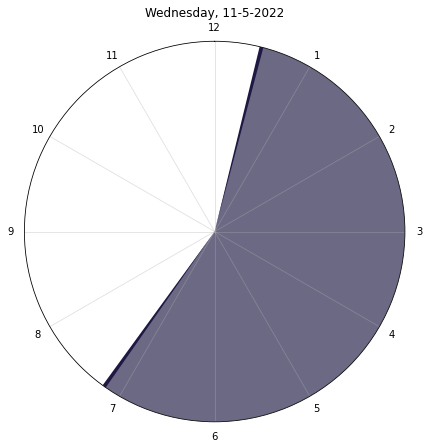

In [18]:
def plot_clock_basic(mini):
    d = mini.iloc[0]['date'].date()
    de = mini.iloc[-1]['date'].date()
    if len(mini) > 1:
        print(f'{len(mini)} days shown')
        alpha = 0.3
        title = f'{mini.iloc[0]["dayOfWeek"]}, {d.day}-{d.month}-{d.year} to {mini.iloc[-1]["dayOfWeek"]}, {de.day}-{de.month}-{de.year}'
    else: 
        alpha = 1
        title = f'{mini.iloc[0]["dayOfWeek"]}, {d.day}-{d.month}-{d.year}'
        
    
    xs = transform(mini['in_bed_time'])
    xw = transform(mini['wake_time'])

    
    fig = plt.figure(figsize=(7,7))
    ax = plt.subplot(111, projection = 'polar')

    ax.bar(xs + (xw-xs)/2, 1, width = (xw-xs), alpha=alpha, color='#6c6984')
    ax.bar(xs, 1, width = 0.02, alpha=1, color='#1e1842')
    ax.bar(xw, 1, width = 0.02, alpha=1, color='#1e1842')

    # Make the labels go clockwise
    ax.set_theta_direction(-1)

    #Place Zero at Top
    ax.set_theta_offset(np.pi/2)

    #Set the circumference ticks
    ax.set_xticks(np.linspace(0, 2*np.pi, 12, endpoint=False))

    # set the label names
    ticks = ['12', '1', '2', '3', '4', '5', '6', '7','8','9','10','11']#,'12 PM', '1 PM', '2 PM', '3 PM', '4 PM',  '5 PM', '6 PM', '7 PM', '8 PM', '9 PM', '10 PM', '11 PM' ]
    ax.set_xticklabels(ticks)

    # suppress the radial labels
    plt.setp(ax.get_yticklabels(), visible=False)

    #Bars to the wall
    plt.ylim(0,1)
    plt.title(title)
    #plt.legend(bbox_to_anchor=(1,0), fancybox=True, shadow=True)
    plt.grid(visible=False, axis='y')
    plt.grid(visible=True, axis='x', alpha=0.4)

    plt.savefig(f'figures/{title}_clock')

    plt.show()
    
plot_clock_basic(mini)

In [19]:
mini

,date,overall_score,composition_score,revitalization_score,duration_score,deep_sleep_in_minutes,resting_heart_rate,restlessness,wake_times,minutesAsleep,...,light,rem,wake,in_bed_time,in_bed_hour,wake_time,wake_hour,in_bed_time (mins),period,dayOfWeek
704,2022-05-11,80,21,21,38,41,69,0.06125,07:11:00,351.0,...,220,90,51,00:28:30,0.0,07:11:00,7.0,402,0,Wednesday


In [20]:
weds = pd.read_json('sleep/sleep-2022-04-19.json')

weds_levels = pd.DataFrame(dict(weds[weds['dateOfSleep']=='2022-05-11']['levels'])[8]['data'])
weds_summary = pd.DataFrame(dict(weds[weds['dateOfSleep']=='2022-05-11']['levels'])[8]['summary'])

In [21]:
weds_levels['num'] = 3

weds_levels['num'][weds_levels['level'] == 'rem'] = 2
weds_levels['num'][weds_levels['level'] == 'light'] = 1
weds_levels['num'][weds_levels['level'] == 'deep'] = 0
weds_levels

/tmp/ipykernel_3218/361952389.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weds_levels['num'][weds_levels['level'] == 'rem'] = 2
/tmp/ipykernel_3218/361952389.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weds_levels['num'][weds_levels['level'] == 'light'] = 1
/tmp/ipykernel_3218/361952389.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weds_levels['num'][weds_levels['level'] == 'deep'] = 0


,dateTime,level,seconds,num
0,2022-05-11T00:28:30.000,wake,270,3
1,2022-05-11T00:33:00.000,light,180,1
2,2022-05-11T00:36:00.000,wake,360,3
3,2022-05-11T00:42:00.000,light,6660,1
4,2022-05-11T02:33:00.000,deep,270,0
5,2022-05-11T02:37:30.000,light,60,1
6,2022-05-11T02:38:30.000,rem,300,2
7,2022-05-11T02:43:30.000,light,180,1
8,2022-05-11T02:46:30.000,deep,480,0
9,2022-05-11T02:54:30.000,light,1380,1


In [22]:
#weds_levels.to_csv('wed_sleep.csv', index=False)
#weds_summary.to_csv('wed_sum.csv', index=False)

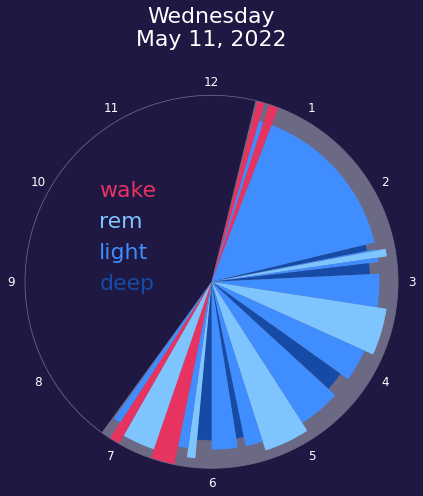

In [23]:
def plot_clock_all(df, levels):  
    d = df.iloc[0]['date'].date()
    alpha = 1
    title = f'{mini.iloc[0]["dayOfWeek"]}\n{d.strftime("%B")} {d.day}, {d.year}'

    xs = transform(mini['in_bed_time'])
    xw = transform(mini['wake_time'])

    
    fig = plt.figure(figsize=(7,7), facecolor='#1e1842')
    ax = plt.subplot(111, projection = 'polar')
    ax.set_facecolor(color='#1e1842')

    ax.bar(xs + (xw-xs)/2, 4.5, width = (xw-xs), alpha=alpha, color='#6c6984')
    ax.bar(xs, 4, width = 0.02, alpha=1, color='#6c6984')
    ax.bar(xw, 4, width = 0.02, alpha=1, color='#6c6984')

    # Make the labels go clockwise
    ax.set_theta_direction(-1)

    #Place Zero at Top
    ax.set_theta_offset(np.pi/2)

    #Set the circumference ticks
    ax.set_xticks(np.linspace(0, 2*np.pi, 12, endpoint=False))

    # set the label names
    ticks = ['12', '1', '2', '3', '4', '5', '6', '7','8','9','10','11']
    ax.set_xticklabels(ticks, fontsize=12, color='#ffffff')

    # suppress the radial labels
    plt.setp(ax.get_yticklabels(), visible=False)

    #Bars to the wall
    plt.ylim(0,4)
    plt.title(title+'\n', fontsize= 22, color='#ffffff')
    
    
    plt.grid(visible=False, axis='y')
    plt.grid(visible=False, axis='x', alpha=0.2)

    #add phases
    cols = {'wake':'#e73360', 'light':'#3f8dff', 'deep':'#154ba6', 'rem':'#7ec4ff'}
    high = {'wake':4, 'rem':3.8, 'light':3.6, 'deep':3.4 }
    
    
    for i in range(len(levels)):
        ti = levels.loc[i]['dateTime'][11:-4]
        xp = transform(ti)
        w = (levels.loc[i]['seconds']/ (12 * 3600))* 2 * np.pi
        
        
        ax.bar(xp + w/2, high[levels.loc[i]['level']], width=w, alpha=1, color=cols[levels.loc[i]['level']])
    
    plt.setp(ax.spines.values(), color='#6c6984')
    
    #print(handles)
    plt.legend(['wake','rem','light','deep'], 
               labelcolor=['#e73360','#7ec4ff','#3f8dff','#154ba6'], 
               loc='center left', 
               handlelength=0,
               frameon = False,
               fontsize=22,
               bbox_to_anchor=(0.099,0.62),
               #title='   Sleep stage',
               #title_fontsize=18,
              )
    plt.tight_layout()
    plt.savefig(f'figures/{title}_stages_clock')
    plt.show()
    
    

#sli = weds_levels[3:4].reset_index(drop=True)
plot_clock_all(mini, weds_levels)

In [24]:
#handles, labels = ax.get_legend_handles_labels()
#[handles[0], handles[6], handles[3], handles[4]],